# Introdução

Este documento nos apóia a realizar e conhecer a análise de desvio das variáveis utilizadas em um modelo.

Em uma plataforma corporativa, este trabalho é automatizado, mas neste laboratório faremos passo a passo para compreensão do que estamos realizando.

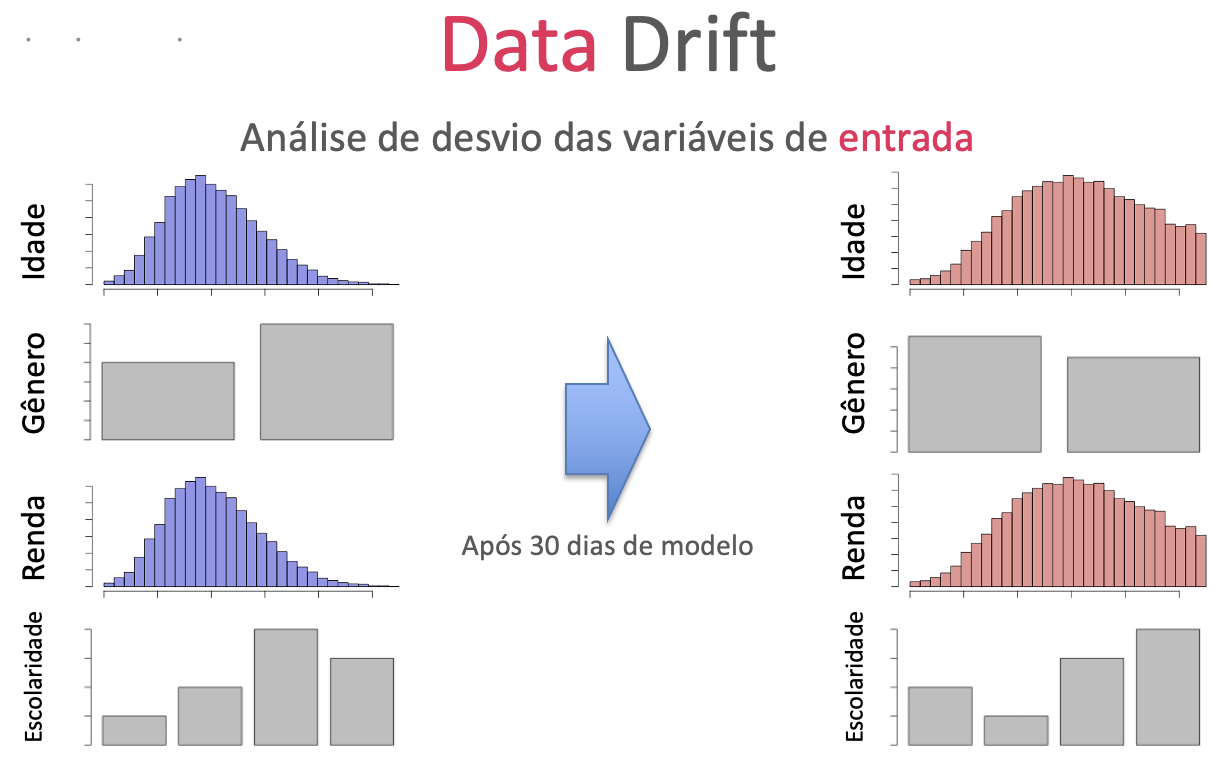

#Setup



<font color="red">Caso apareça um botão como esse durante o setup, deve ser necessário reiniciar o "Runtime"</font>


Pode ser feito clicando no botão ou pelo menu do Colab.

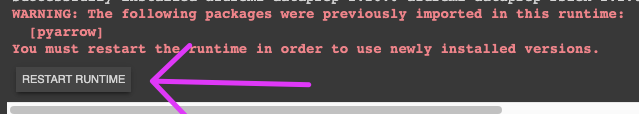

In [1]:
!git clone https://github.com/elthonf/azure-ml.git

Bibliotecas auxiliares

In [2]:
import numpy as np
import pandas as pd
import math, random, json
from scipy.stats.stats import pearsonr   
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Funções auxuliares

In [3]:
def describe(df):
    return pd.concat([df.describe(include="all", percentiles=[.1, .2, .25, .3, .4, .5, .6, .7, .75, .8, .9]).T,
                      df.dtypes.rename('dtypes'),
                      df.mad().rename('mad'),
                      #df.skew().rename('skew'),
                      #df.kurt().rename('kurt'),
                      df.nunique().rename('nunique'),
                     ], axis=1)
def describe_cols(df, df_summary=None):
  if df_summary is None:
    df_summary = describe(df)
  ret = {}
  for i, row in df_summary.iterrows():
    if row["nunique"] <= 100:
      ret[i] = {"classes" : json.loads( df.groupby([i]).size().to_json() ) }
    elif np.issubdtype(row["dtypes"], np.number):
      _h = np.histogram(df[i])
      _h2 = np.histogram(df[i], density=True)
      ret[i] = {"hist": list(_h[0]),
                "density": list(_h2[0]),
                "bin_edges": list(_h[1]),
                "bin_edgesv2": [-np.inf] + list(_h[1][1:-1]) + [np.inf] }
    else:
      ret[i] = {}
  return ret

# Obtenção de Dados

## Obter referência (baseline)

In [4]:
mybase = pd.read_csv("./azure-ml/datasets/statistical/BaseDefault01.csv")

In [2]:
mybase_metadata = describe(mybase)
mybase_counts = describe_cols(mybase, mybase_metadata)
mybase_metadata

## Obter Scorings atuais

Obs.: Considerar sempre um critério, como janela móvel, toda a base, últimos n registros, etc.

In [6]:
myactual = pd.read_csv("./azure-ml/datasets/statistical/BaseMesAnterior.csv")

In [3]:
myactual_metadata = describe(myactual)
myactual_counts = describe_cols(myactual, myactual_metadata)
myactual_metadata

# Data Drift

In [8]:
def get_data_for_histogram(coluna):
  labels = [ f"{mybase_counts[coluna]['bin_edgesv2'][i]} - {mybase_counts[coluna]['bin_edgesv2'][i+1]} " for i in list(range(len(mybase_counts[coluna]['hist']))) ]; labels
  y1h = mybase_counts[coluna]['hist']
  y2h = np.histogram(myactual[coluna], bins= mybase_counts[coluna]["bin_edgesv2"])[0]
  y1hp = y1h / np.sum(y1h)
  y2hp = y2h / np.sum(y2h)
  y1d = mybase_counts[coluna]['density']
  y2d = np.histogram(myactual[coluna], bins= mybase_counts[coluna]["bin_edgesv2"], density=True)[0]

  yprop_change = y2hp - y1hp
  yprop_c_mabs = np.mean( np.abs(yprop_change) )
  yd_change = y2d - y1d

  return {"x": labels,
          "y1h": y1h, "y2h": y2h,
          "y1hp": y1hp, "y2hp": y2hp,
          "y1d": y1d, "y2d": y2d,
          "yprop_change": yprop_change, "yprop_c_mabs": yprop_c_mabs,
          "yd_change": yd_change,
          "correlacao": pearsonr(y1h, y2h)}

def display_histogram(coluna, show=False):
  analise = get_data_for_histogram(coluna=coluna)

  fig1 = make_subplots(specs=[[{"secondary_y": True}]])
  fig1.add_trace(go.Bar(x=analise.get("x"),
                        y=analise.get("y1d"),
                        name='baseline'))
  fig1.add_trace(go.Bar(x=analise.get("x"),
                        y=analise.get("y2d"),
                        name='actual'))
  fig1.add_trace(go.Scatter(x=analise.get("x"),
                        y=analise.get("yd_change"), mode='lines+markers',
                        name='variação'), secondary_y=True)
  fig1.update_layout(
      title=f"Análise densidade da coluna {coluna}. Corr = {analise.get('correlacao')[0]}")

  fig2 = make_subplots(specs=[[{"secondary_y": True}]])
  fig2.add_trace(go.Bar(x=analise.get("x"),
                        y=analise.get("y1hp"),
                        name='baseline'))
  fig2.add_trace(go.Bar(x=analise.get("x"),
                        y=analise.get("y2hp"),
                        name='actual'))
  fig2.add_trace(go.Scatter(x=analise.get("x"),
                        y=analise.get("yprop_change"), mode='lines+markers',
                        name='variação'), secondary_y=True)
  fig2.update_layout(
      title=f"Análise distribuição da coluna {coluna}. Corr: {analise.get('correlacao')[0]}. Média variação abs relativa: {analise.get('yprop_c_mabs')}")
  if show:
    fig1.show()
    fig2.show()
  return analise, fig1, fig2

def display_boxplot(coluna, show=False):
  fig = go.Figure()
  fig.add_trace(go.Box(x=mybase[coluna], name='baseline'))
  fig.add_trace(go.Box(x=myactual[coluna], name='actual'))
  if show:
    fig.show()
  return fig

def display_percentis(coluna, show=False):
  vx =  [0.0,      .1,    .2,    .3,    .4,    .5,    .6,    .7,    .8,    .9,   1.0]
  vyh = ["min", '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', "max"]
  vy1 = mybase_metadata.loc[coluna, vyh]
  vy2 = myactual_metadata.loc[coluna, vyh]
  vyv = [(vy2[h] - vy1[h]) / (vy1[h] or pd.NA) for h in vyh]
  correlacao =  pearsonr(vy1, vy2)

  #fig = go.Figure()
  fig = make_subplots(specs=[[{"secondary_y": True}]])
  fig.add_trace(go.Scatter(x=vyh, y=vy1, mode='lines+markers', name='baseline'))
  fig.add_trace(go.Scatter(x=vyh, y=vy2, mode='lines+markers', name='actual'))
  #fig.add_trace(go.Scatter(x=vx, y=vyv, mode='lines+markers', name='variacao'), secondary_y=True)
  fig.add_trace(go.Bar(x=vyh, y=vyv, name='variacao'), secondary_y=True)

  #add_bar

  fig.update_layout(
      title=f"Análise Decis da coluna {coluna}. Corr = {correlacao[0]}")
  if show:
    fig.show()

  return {"vx": vx,
          "vyh": vyh,
          "vy1": vy1,
          "vy2": vy2,
          "vyv": vyv,
          "correlacao": correlacao}, fig


In [9]:
def get_data_for_histogramc(coluna):
  labels = list(mybase_counts[coluna].get('classes', {}).keys())
  y1h = [mybase_counts[coluna].get('classes', {}).get(k)  for k in labels]
  y2h = [myactual_counts.get(coluna, {}).get('classes', {}).get(k, 0)  for k in labels]
  y1hp = y1h / np.sum(y1h)
  y2hp = y2h / np.sum(y2h)

  yprop_change = y2hp - y1hp
  yprop_c_mabs = np.mean( np.abs(yprop_change) )

  return {"x": labels,
          "y1h": y1h, "y2h": y2h,
          "y1hp": y1hp, "y2hp": y2hp,
          "yprop_change": yprop_change, "yprop_c_mabs": yprop_c_mabs,
          "correlacao": pearsonr(y1h, y2h)}


def display_histogramc(coluna, show=False):
  analise = get_data_for_histogramc(coluna=coluna)

  #fig2 = go.Figure()
  fig2 = make_subplots(specs=[[{"secondary_y": True}]])
  fig2.add_trace(go.Bar(x=analise.get("x"),
                        y=analise.get("y1hp"),
                        name='baseline'))
  fig2.add_trace(go.Bar(x=analise.get("x"),
                        y=analise.get("y2hp"),
                        name='actual'))
  fig2.add_trace(go.Scatter(x=analise.get("x"),
                        y=analise.get("yprop_change"), mode='lines+markers',
                        name='variação'), secondary_y=True)
  fig2.update_layout(
      title=f"Análise distribuição da coluna {coluna}. Média variação abs relativa: {analise.get('yprop_c_mabs')}")
  if show:
    fig2.show()
  return analise, fig2

## Avaliação global

Avalia as principais variações de Média, mediana, quantidade de observações, desvio padrão, etc.

In [6]:
mystats = {}
for c in list(mybase_metadata.index):
  mystats[c] = {}
  mystats[c][f"dtypes"] = mybase_metadata.loc[c, "dtypes"]
  for m in ["nunique", "mean", "50%", "std"]:
    mystats[c][f"{m}.base"] = mybase_metadata.loc[c, m]
    mystats[c][f"{m}.actual"] = pd.NA if c not in list(myactual_metadata.index) else myactual_metadata.loc[c, m]
    mystats[c][f"{m}.var"] = (mystats[c][f"{m}.actual"] - mystats[c][f"{m}.base"] ) / (mystats[c][f"{m}.base"] or pd.NA)
mystats = pd.DataFrame(mystats).T
mystats

## Análise de Data Drift, coluna a coluna


### Coluna `renda`


In [7]:
h0, h1, h2 = display_histogram('renda'); h2.show(); h1.show()
display_boxplot("renda").show()
p0, p1 = display_percentis('renda'); p1.show()

### Coluna `idade`

In [8]:
h0, h1, h2 = display_histogram('idade'); h2.show();  h1.show()
display_boxplot("idade").show()
p0, p1 = display_percentis('idade'); p1.show()

### Colunas categóricas 
```
'etnia', 'sexo', 'casapropria', 'outrasrendas', 'estadocivil', 'escolaridade', 'default'
```

In [9]:
for c in ['etnia', 'sexo', 'casapropria',
       'outrasrendas', 'estadocivil', 'escolaridade', 'default']:
  h0, h1 = display_histogramc(c, show=False); h1.show()

# Tarefa

Agora analise os dados do mês atual, que estão disponíveis no arquivo `BaseMesAnterior`

## Conclusão:

Digamos que a tolerância de Data Drift de Todas as colunas é de 15% se comparado à distrbuição da referência.

Neste caso, o monitoramento deve alertar para novo treinamento do modelo? Por quê?